In [41]:
import cv2 
import matplotlib.pyplot as plt 
import torch, torchvision 
from torchvision import transforms 
import numpy as np 
import os, time, json, uuid 
import matplotlib 
from PIL import Image 
from torchinfo import summary

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
np.random.seed(0)

In [38]:
class Transform():
    def __init__(self):
        self.data_transform = transforms.Compose([
                                                  transforms.ToTensor()
        ])
    def __call__(self, img):
        return self.data_transform(img)


In [36]:
def load_model():
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True, num_keypoints=17)
    model.to(device)
    model.eval()
    return model 

def show_img(outputs, image):
    image = decode_img(outputs, image)
    fig = plt.figure()
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    os.makedirs("results", exist_ok=True)
    id = uuid.uuid4()
    fig.savefig(f"results/{str(id)[:4]}.png")
    print(f"saving resutl image for path results/{str(id)[:4]}.png")

def inference(img_path: str):
    # モデルの読み込み
    model = load_model()
    transform = Transform()
    # 前処理と表示する画像の調整
    img = Image.open(img_path)
    orgImg = np.array(img, dtype=np.float32)
    orgImg = cv2.cvtColor(orgImg, cv2.COLOR_RGB2BGR) / 255.
    img_tensor = transform(img).unsqueeze(0)
    # 推論
    with torch.no_grad():
        outputs = model(img_tensor)
    show_img(outputs, orgImg)



In [35]:
# 関節同士の組み合わせの分だけ座標を求めてイメージとする
# 参照 https://debuggercafe.com/human-pose-detection-using-pytorch-keypoint-rcnn/
edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
    (12, 14), (14, 16), (5, 6)
]

def decode_img(outputs, image):
    for ii in range(outputs[0]["scores"].size()[0]): # 認識された人数の分だけループさせる
        if outputs[0]["scores"][ii].item() > 0.9:
            keypoints = outputs[0]["keypoints"][ii].detach().cpu().numpy()
            for i in range(len(keypoints)):
                pos = keypoints[i]
                x = int(pos[0])
                y = int(pos[1])
                cv2.circle(image, (x, y) ,3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

            for ie, (e1, e2) in enumerate(edges):
                rgb = matplotlib.colors.hsv_to_rgb([
                                                    ie/float(len(edges)), 1.0, 1.0
                ])
                rgb = rgb * 255
                x1 = int(keypoints[e1][0])
                y1 = int(keypoints[e1][1])
                x2 = int(keypoints[e2][0])
                y2 = int(keypoints[e2][1])
                cv2.line(image, (x1, y1), (x2, y2), tuple(rgb), 2, lineType=cv2.LINE_AA)
        else:
            continue
    return image 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saving resutl image for path results/db20.png


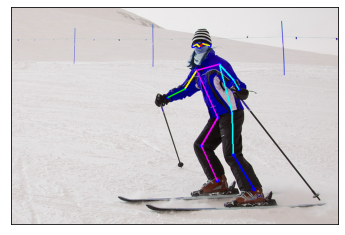

In [37]:
inference("1.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


saving resutl image for path results/6973.png


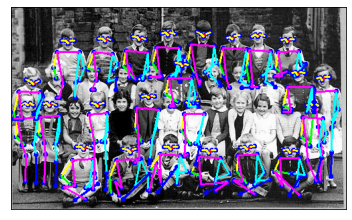

In [39]:
inference("4.jpg")

In [42]:
summary(model, input_size=(2, 3, 368, 368))

Layer (type:depth-idx)                                  Output Shape              Param #
KeypointRCNN                                            --                        --
├─BackboneWithFPN: 1                                    --                        --
│    └─FeaturePyramidNetwork: 2                         --                        --
│    │    └─ModuleList: 3-1                             --                        984,064
│    │    └─ModuleList: 3-2                             --                        2,360,320
├─GeneralizedRCNNTransform: 1-1                         --                        --
├─BackboneWithFPN: 1-2                                  [2, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [2, 2048, 25, 25]         --
│    │    └─Conv2d: 3-3                                 [2, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-4                      [2, 64, 400, 400]         --
│    │    └─ReLU: 3-5                      